# TODO
- just test with pytorch on the artificial example
- write the formula of the derivative definition (numerical gradients) in the report

In [3]:
import numpy as np
import h5py


fn = "image1-competition.hdf5"

with h5py.File(fn, "r") as f:
    data = np.array(f["data"])
    wns = np.array(f["wns"])
    tissue_mask = np.array(f["tissue_mask"])
    classes = np.array(f["classes"])

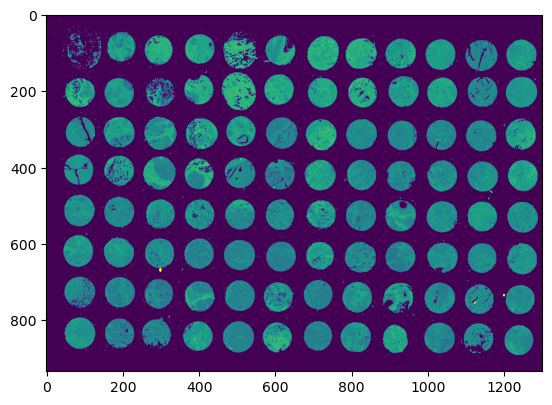

In [4]:
# display the whole image
import matplotlib.pyplot as plt

def nearest_ind(a, v):
    return np.abs(a - v).argmin()

im = data[:, :, nearest_ind(wns, 1560)]
plot = plt.imshow(im, vmin=0, vmax=1)

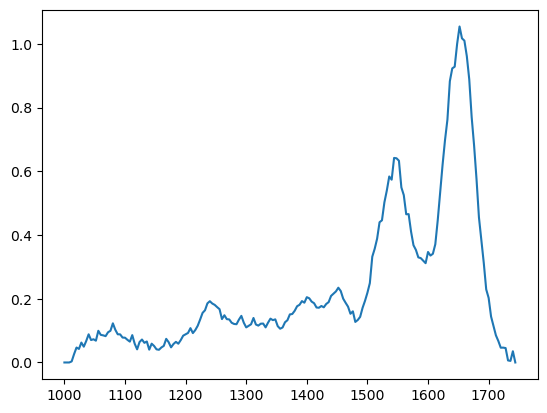

In [5]:
# a single "pixel" is a spectrum
plt.plot(wns, data[110, 220])
plt.show()

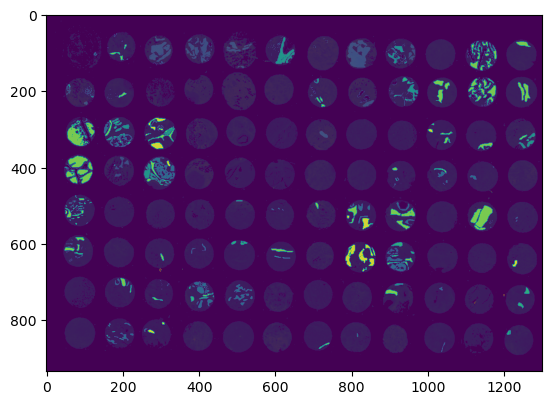

In [6]:
# the classes
plt.imshow(data[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)
plt.imshow(classes[:, :], alpha=0.8)

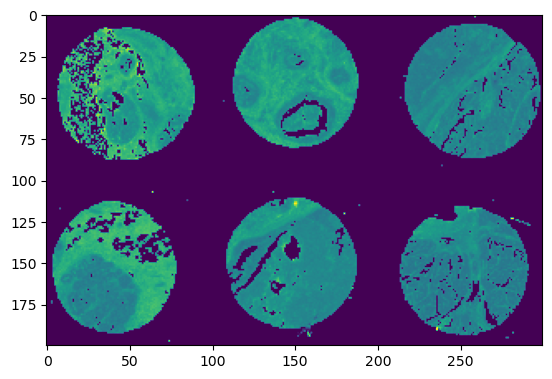

In [7]:
data_predict = data[265:465,360:660]
plt.imshow(data_predict[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)

In [8]:
# Multinomial Logistic Regresion that disregards image coordinates
from sklearn.metrics import log_loss

annotated_sel = classes != -1
X = data[annotated_sel]
y = classes[annotated_sel]

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

lr = LogisticRegression(max_iter=10000, C=0.001)
lr.fit(X, y)

LogisticRegression(C=0.001, max_iter=10000)

In [9]:
# take spectra for prediction in a linearized sequence
lin_data_predict = data_predict.reshape(-1, data_predict.shape[-1])
lin_data_predict = scaler.transform(lin_data_predict)

lin_pred = lr.predict_proba(lin_data_predict)
pred = lin_pred.reshape(data_predict.shape[:2] + lin_pred.shape[-1:])

with open("multilogreg.npy", "wb") as f:
    np.save(f, pred.astype(np.float32))


In [10]:
import torch
import torch.nn as nn

class SpectralMLP(nn.Module):
    def __init__(self, input_features=187, num_classes=3):
        super(SpectralMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [11]:
class Conv1D(nn.Module):
    def __init__(self, input_features=187, num_classes=3):
        super(Conv1D, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=1),  # Adjusted kernel size to 1
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=1),  # Adjusted kernel size to 1
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * input_features, num_classes)  # Updated the input size to match the flattened output
        )

    def forward(self, x):
        # Ensure x is in the shape [batch_size, 1, 187] (1 channel, 187 length)
        x = x.unsqueeze(1)  # Add the channel dimension (Converts from [batch_size, 187] to [batch_size, 1, 187])
        return self.net(x)




In [12]:
from torch.functional import F

class SpectralCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SpectralCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        # The size here should match the output shape after convolutions
        self.fc1 = nn.Linear(64 * 43, 128)  # Correct the size based on the flattened si
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension (shape becomes [batch_size, 1, num_wavelengths])
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [13]:
class SpectralRNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SpectralRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.fc1 = nn.Linear(64, num_classes)


    def forward(self, x):
        x = x.unsqueeze(2)  # Convert shape to [batch_size, num_wavelengths, 1]
        lstm_out, (hn, cn) = self.lstm(x)
        x = F.relu(self.fc1(hn[-1]))  # Use the last hidden state
        return x

In [14]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import numpy as np

annotated_sel = classes != -1
X = data[annotated_sel]  
y = classes[annotated_sel]

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y)

# Convert to tensors and move to device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
batch_size = 64  # Adjust based on available memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


In [22]:
# Model, loss, optimizer
model = SpectralMLP(X_train.shape[1], len(np.unique(y))).to(device)
# model = Conv1D(X_train.shape[1], len(np.unique(y))).to(device)
# model = SpectralCNN(X_train.shape[1], len(np.unique(y))).to(device)
#model = SpectralRNN(1, len(np.unique(y))).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Training loop with batching
epochs = 50
torch.manual_seed(42)

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move batch to GPU/CPU
        
        optimizer.zero_grad()

        # Forward pass
        pred_logits = model(batch_X)

        # Compute loss
        loss = loss_fn(pred_logits, batch_y)
        loss.backward()

        # Update model weights
        optimizer.step()

        # Accumulate the loss for averaging later
        running_train_loss += loss.item()

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.inference_mode():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            val_logits = model(batch_X)
            val_loss = loss_fn(val_logits, batch_y)

            # Accumulate validation loss
            running_val_loss += val_loss.item()

            # Calculate accuracy
            _, predicted = torch.max(val_logits, 1)
            correct_preds += (predicted == batch_y).sum().item()
            total_preds += batch_y.size(0)

    # Calculate average loss and accuracy
    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)
    val_acc = correct_preds / total_preds

    print(f"Epoch {epoch+1}/{epochs}: Train loss={avg_train_loss:.4f}, Val loss={avg_val_loss:.4f}, Val acc={val_acc:.4f}")

Epoch 1/50: Train loss=0.4583, Val loss=0.2875, Val acc=0.8946
Epoch 2/50: Train loss=0.2716, Val loss=0.2543, Val acc=0.9036
Epoch 3/50: Train loss=0.2426, Val loss=0.2693, Val acc=0.9036
Epoch 4/50: Train loss=0.2232, Val loss=0.2205, Val acc=0.9143
Epoch 5/50: Train loss=0.2152, Val loss=0.2087, Val acc=0.9178
Epoch 6/50: Train loss=0.2017, Val loss=0.1990, Val acc=0.9235
Epoch 7/50: Train loss=0.1979, Val loss=0.2126, Val acc=0.9156
Epoch 8/50: Train loss=0.1837, Val loss=0.1793, Val acc=0.9313
Epoch 9/50: Train loss=0.1804, Val loss=0.2118, Val acc=0.9178
Epoch 10/50: Train loss=0.1759, Val loss=0.1971, Val acc=0.9230
Epoch 11/50: Train loss=0.1725, Val loss=0.1684, Val acc=0.9385
Epoch 12/50: Train loss=0.1727, Val loss=0.1698, Val acc=0.9362
Epoch 13/50: Train loss=0.1643, Val loss=0.1788, Val acc=0.9285
Epoch 14/50: Train loss=0.1598, Val loss=0.1862, Val acc=0.9253
Epoch 15/50: Train loss=0.1567, Val loss=0.1743, Val acc=0.9337
Epoch 16/50: Train loss=0.1560, Val loss=0.1653, 

In [23]:
# take spectra for prediction in a linearized sequence
lin_data_predict = data_predict.reshape(-1, data_predict.shape[-1])
lin_data_predict = scaler.transform(lin_data_predict)


lin_data_predict_tensor = torch.tensor(lin_data_predict, dtype=torch.float32).to(device) 

# Predict
model.eval()
with torch.inference_mode():
    pred_logits = model(lin_data_predict_tensor)
    pred_probs = torch.softmax(pred_logits, dim=1) 


# Reshape the predicted probabilities to match the data dimensions
pred_probs_reshaped = pred_probs.cpu().numpy().reshape(data_predict.shape[:2] + (-1,))

# Save the probabilities
np.save("basic_prediction_probs.npy", pred_probs_reshaped.astype(np.float32))
